## Tweet Emotion Recognition: Natural Language Processing with TensorFlow



## Task 1: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


## Task 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [6]:
!pip install datasets==2.9.0

from datasets import load_dataset
ds = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
ds


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
train=ds['train']
val=ds['validation']
test=ds['test']

In [16]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  label=[x['label'] for x in data]
  return tweets,label

In [17]:
tweet,label=get_tweet(train)

In [18]:
tweet[0],label[0]

('i didnt feel humiliated', 0)

## Task 3: Tokenizer

1. Tokenizing the tweets

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweet)

In [26]:
print(tokenizer.texts_to_sequences([tweet[0]]))
tweet[0]

[[2, 139, 3, 679]]


'i didnt feel humiliated'

## Task 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

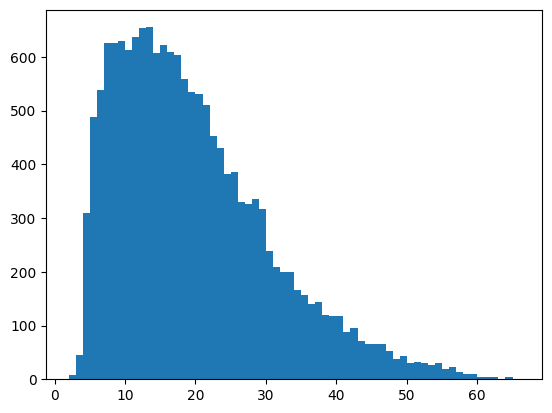

In [28]:
lengths=[len(t.split(' ')) for t in tweet]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [30]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
def get_sequence(tokenizer,tweets):  #this makes sure that the examples are of same size
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating="post",padding="post",maxlen=maxlen)
  return padded

In [42]:
padded_train_seq=get_sequence(tokenizer,tweet)


In [43]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 5: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [50]:
classes= set(label)
print(classes)
#{  0    ,   1  ,   2 ,    3    ,  4  , 5  }
#{sadness, anger, love, surprise, fear, joy}

{0, 1, 2, 3, 4, 5}


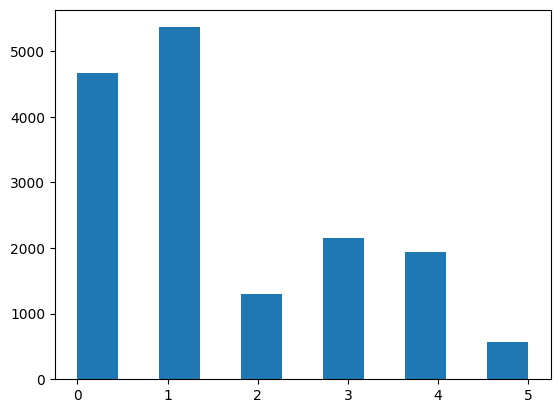

In [51]:
plt.hist(label,bins=11)
plt.show()

In [54]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v, in class_to_index.items())

In [55]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [56]:
names_to_ids= lambda labels: np.array([class_to_index.get(x) for x in labels])

In [58]:
train_labels=names_to_ids(label)
print(train_labels[0])

0


## Task 6: Creating the Model

1. Creating the model
2. Compiling the model

In [63]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 7: Training the Model

1. Preparing a validation set
2. Training the model

In [66]:
val_tweets,val_labels=get_tweet(val)
val_sequence=get_sequence(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [71]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [75]:
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_sequence,val_labels),
    epochs=20,
    callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 38s 58ms/step - loss: 1.2926 - accuracy: 0.4916 - val_loss: 0.7800 - val_accuracy: 0.7085
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.4822 - accuracy: 0.8444 - val_loss: 0.4086 - val_accuracy: 0.8605
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2258 - accuracy: 0.9272 - val_loss: 0.3833 - val_accuracy: 0.8725
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1445 - accuracy: 0.9527 - val_loss: 0.3745 - val_accuracy: 0.8790
Epoch 5/20
500/500 [==============================] - 12s 25ms/step - loss: 0.1072 - accuracy: 0.9649 - val_loss: 0.3636 - val_accuracy: 0.8855
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.1035 - accuracy: 0.9659 - val_loss: 0.3411 - val_accuracy: 0.8945
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.0778 - accuracy: 0.9744 - val_loss: 0.4239 - val_accuracy: 

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

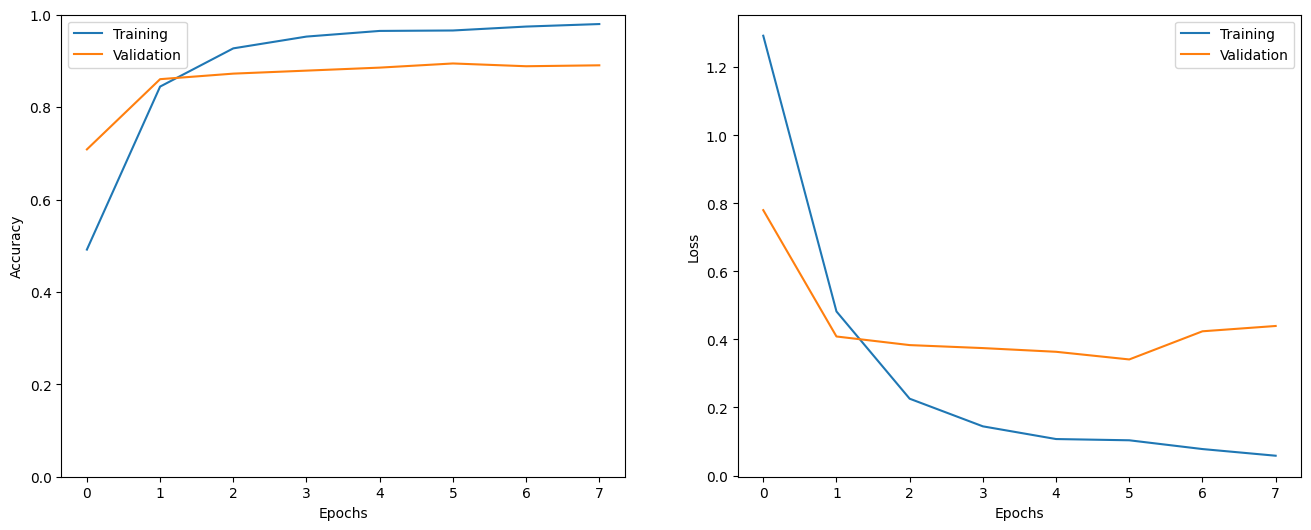

In [76]:
show_history(h)

In [78]:
test_tweet,test_label=get_tweet(test)
test_seq=get_sequence(tokenizer,test_tweet)
test_labels=names_to_ids(test_label)

In [79]:
_=model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.4356 - accuracy: 0.8830


In [82]:
i=random.randint(0,len(test_label)-1)
print("Sentence: ",test_tweet[i])
print("Emotion: ",index_to_class[test_label[i]])
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion: ',pred_class)

Sentence:  i wish him and i could go out and i could do my hair and makeup and feel cute and flirt and talk and stuff but that never occurs
Emotion:  1
1/1 [==============================] - 0s 37ms/step
Predicted Emotion:  1
